# Training a Neural Net

- Now that we have an undertanding of what *training* is, let's try it out!
- I'll use **Keras**, a wrapper that takes care of the low-level configuration of **TensorFlow**
- Only need the concepts of *neurons*, *layers*, *activtion function* etc. to build a NN in Keras 

# Training requires **data**

- Kaggle Higgs ML challenge

   - In 2014, Kaggle (online ML community) partnered with ATLAS to stage an ML competition
   - Teams were given signal ($H \rightarrow\tau \tau$) and background ($Z \rightarrow \tau \tau \;, t\bar{t} \;, W \rightarrow e/\mu$) simulation
   - The best classification performance (best *Approximate Median Significance*) wins!

    # I'll use this dataset to demo the training of a classification NN


In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1234)

import matplotlib
matplotlib.rcParams['font.size'] = 16
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing  

In [3]:
df = pd.read_csv("atlas-higgs-challenge-2014-v2.csv")
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,...,1.190,-0.766,41.791,0.787,-1.090,154.056,0.005721,s,u,0.259892
818234,918234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,...,1.293,-0.868,70.158,-2.018,2.893,178.856,0.000461,s,u,0.020956
818235,918235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.189365,b,u,53.284258
818236,918236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,...,1.460,2.637,-999.000,-999.000,-999.000,30.863,0.512740,b,u,22.971060


# Data pre-processing

- extract -
   - variables that discriminate between signal and background (*features*)
   - labels that indicate whether the event is *signal* or *background*
   - weights that tell us how much that event should count in the loss function... Why?

- arrange this data in separate synchronous dataframe columns (or numpy arrays)

# Data pre-processing

- Split data into approximately equally-sized *training* and *test* set
    - training set used to directly alter weights and biases and minimise loss function
    - test set used to check performace and generalisability of network as batches passed through network
    
    
- loss(training) and loss(test) sets decreases as training proceeds
    - eventually, loss(training) $<$ loss(test) as network learns statitical fluctuations of training set
    - This is **over-training** and needs to be avoided at all costs... Why is it so bad?
        - In Keras usually terminate training once loss(training) $<<$ loss(test)

In [122]:
#extract features, labels, and event-weights
Labels=df['Label']

lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(Labels)
features = df.iloc[:,1:31]

X=features
y=np.ravel(labels)

print("Number of signal events = " + str(np.count_nonzero(y == 1)))
print("Number of background events = " + str(np.count_nonzero(y == 0)))
print("labels = " + str(labels))


weights = df['Weight']
weights=np.ravel(weights) 

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.33, random_state=42, shuffle=True)

Number of signal events = 279560
Number of background events = 538678
labels = [[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


# How do we weight MC events in general?

- we require our histograms to:
   - represent our expected data under some hypothesis

-  therefore the final weight must include:
   - the cross section of the process, the luminosity
   - weights (sometimes negative) produced by the MC generator
   - weights that correct for known deficiences in the simulation
       - e.g. b-tagging or trigger scale factors
   
$$ w_{final}  = \sigma * \mathcal{L} * w_{MC} * (w_{trigger} * w_{b-tagging} \dots etc.) $$

# What about when we are training an ML algorithm?

- **optimally**, we want our training simulation to look like our data

-  therefore the training simulation should include:
   - the cross section of the process??, ~~the luminosity of the dataset~~
   - weights (sometimes negative) produced by the MC generator
   - weights that correct for known deficiences in the simulation
       - e.g. b-tagging or trigger scale factors 

# In the case of a rare signal, this approach can lead to an undeperforming NN !

- NN aims to discriminate between labelled data classes: S and B ($t = 1,0$)
- The NN output, $p(x)$ (discriminator), is the predicted probability for the S class 
- Training NN minimises a **loss function**  
- The *binary cross-entropy* for weighted events becomes:
$$ C_{B} = \sum_i - \big[ ( t* \ln p(x_i))  + (1-t)*(\ln (1-p(x_i)) ) \big] * w_{i}$$

# weighting strategies
- 1. **ignore weights altogether**: 
     - the relative contribution of the S and B classes to the loss function will depend on how many MC events of each class you generated!! ¯\_(ツ)_/¯
     - relative contributions of processes within mixed background class won't correspond to the SM! ¯\_(ツ)_/¯
- 2. **use $w_{final}$**
   - theoretically correct *weighted mixture* of processes
   - rare signal hardly contributes to the loss function at all! 
      - classifying $\approx$ all events as background would give $\approx$ 100% accuracy
- 3. **use $w_{final}$: but give signal events a final constant weight such that** $$\sum w^b_i = \sum w^s_i$$

# Define network 'architecture'

- How many neurons, how many layers?
- What activation function? What loss function?

In [203]:
def buildModel(X_train, y_train, weights_train, sigScale, loss, depth, width):
    
    df_train = pd.DataFrame()
    df_train["label"] = y_train
    df_train["weights"] = weights_train
    
    sigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
    bkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])

    #scale = sigScale*(bkgSumWeights/sigSumWeights)
    #df_train.loc[df_train.label==1, "weights"] *= scale

    final_weights_train = df_train["weights"]
    
    model = Sequential()
    model.add(Dense(width, input_dim=width, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=None))
    for layer in range(0, depth):
        model.add(Dense(15, activation="relu", kernel_regularizer=None))
    model.add(Dense(1, activation='sigmoid'))
    #model.add_loss( sigLoss( y_train, X_train, final_weights_train) )
    model.compile(loss=loss, optimizer='adam')   
    history = model.fit(X_train, y_train, sample_weight=final_weights_train, epochs=8, batch_size=100, verbose=1)
    
    return model

In [192]:
def discPlots(text, model, X_test, y_test, weights_test):
    pred_test = model.predict(X_test)

    dfNN = pd.DataFrame()
    dfNN["labels"] = y_test
    dfNN["predictions"] = pred_test
    dfNN["weights"] = weights_test

    signalVals = dfNN[dfNN['labels']== 1] 
    backgroundVals = dfNN[dfNN['labels']== 0] 

    binsAr = np.linspace(0.0, 1.0, 15)
    sigHistNN, bins = np.histogram(signalVals["predictions"], bins=binsAr, weights=signalVals["weights"])
    bkgHistNN, bins = np.histogram(backgroundVals["predictions"],  bins=binsAr, weights=backgroundVals["weights"])
 
    return sigHistNN, bkgHistNN, bins

In [9]:
def getSig(bins, sigHist, bkgHist):

    binCentres = (bins[:-1] + bins[1:]) / 2
    width = bins[1] - bins[0]
    sigmasNN = np.array([])
    sigmasVar = np.array([])

    for x in range(0,len(binCentres)):
        indices = [x, (len(binCentres)-1)] 
        if (bkgHist[indices].sum() != 0):
            sigma = (sigHist[indices].sum()) / ( np.sqrt(sigHist[indices].sum() + bkgHist[indices].sum() ))
        else:
            sigma = 0.001
        sigmasNN = np.append(sigmasNN, sigma)
        
    return binCentres, sigmasNN

Epoch 1/8
5483/5483 [==============================] - 4s 644us/step - loss: 0.3341
Epoch 2/8
5483/5483 [==============================] - 3s 614us/step - loss: 0.1622
Epoch 3/8
5483/5483 [==============================] - 3s 608us/step - loss: 0.1418
Epoch 4/8
5483/5483 [==============================] - 3s 620us/step - loss: 0.1270
Epoch 5/8
5483/5483 [==============================] - 3s 604us/step - loss: 0.1199
Epoch 6/8
5483/5483 [==============================] - 3s 621us/step - loss: 0.1153
Epoch 7/8
5483/5483 [==============================] - 3s 611us/step - loss: 0.1115
Epoch 8/8
5483/5483 [==============================] - 3s 605us/step - loss: 0.1078
bins = [0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5        0.57142857 0.64285714 0.71428571 0.78571429
 0.85714286 0.92857143 1.        ]
Epoch 1/8
5483/5483 [==============================] - 4s 616us/step - loss: 1.0037
Epoch 2/8
5483/5483 [==============================] - 3s 621us/step

5483/5483 [==============================] - 3s 626us/step - loss: 0.9290
Epoch 8/8
5483/5483 [==============================] - 4s 643us/step - loss: 0.9120
bins = [0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5        0.57142857 0.64285714 0.71428571 0.78571429
 0.85714286 0.92857143 1.        ]


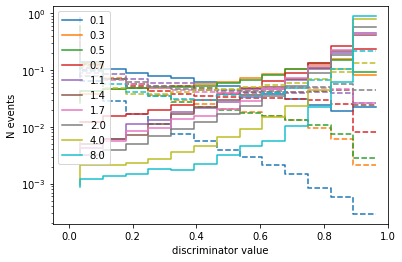

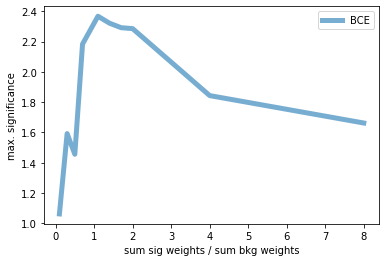

In [202]:
#loop over scalings and make plots

sigScales = [0.1, 0.3, 0.5, 0.7, 1.1, 1.4, 1.7, 2.0, 4.0, 8.0]

maxSigs = np.array([])

plt.figure()
for scale in sigScales:
         
    model = buildModel(X_train, y_train, weights_train, scale, "binary_crossentropy", 1, 30)

    sigHistNN, bkgHistNN, bins = discPlots("BCE", model, X_test, y_test, weights_test)
    binCentres, sigmasNN = getSig(bins, sigHistNN, bkgHistNN)
 
    discBinCentres = (bins[:-1] + bins[1:]) / 2

    #scale sig to match bkg normliastion for the sake of illustration
    sigHistNN = ((1.0)/(np.sum(sigHistNN)))*sigHistNN
    bkgHistNN = ((1.0)/(np.sum(bkgHistNN)))*bkgHistNN

    print("bins = " + str(bins))
    binCentres = (bins[:-1] + bins[1:]) / 2

    bkg = plt.step(binCentres, bkgHistNN, linestyle='--', drawstyle='steps')
    sig = plt.step(binCentres, sigHistNN, color=bkg[0].get_color(), drawstyle='steps', label=str(scale))
    plt.xlim([-0.05, 1.0])
    
    maxSig = np.max(sigmasNN)
    maxSigs = np.append(maxSigs, maxSig)

plt.xlabel("discriminator value")
plt.ylabel("N events")
plt.legend(loc=2)
plt.yscale("log")
plt.show()

fig, ax2 = plt.subplots()
plt.xlabel("sum sig weights / sum bkg weights")
plt.ylabel("max. significance")
ax2.plot(sigScales,maxSigs, label="BCE", lw=5, alpha=0.6)
plt.legend()    
plt.show()

In [214]:
def sigLoss(y_true,y_pred):

    y_true = float(y_true)
    y_pred = float(y_pred)
    
    s_pred  = y_pred*y_true
    b_pred  = y_pred*(1-y_true)
    
    s_cut = float(s_pred > 0.1)
    b_cut = float(b_pred > 0.1)
    
    s = K.sum(s_pred*s_cut)
    b = K.sum(b_pred*b_cut)

    return -(s*s)/(s + b + K.epsilon() )


def sigLoss2(y_true,y_pred):
    y_true = float(y_true)
    y_pred = float(y_pred)

    signalWeight=1.0/K.sum(y_true)
    bkgdWeight=1.0/K.sum(1-y_true)

    s = signalWeight*K.sum(y_pred*y_true)
    b = bkgdWeight*K.sum(y_pred*(1-y_true))

    return -(s*s)/(s+b+K.epsilon())

Epoch 1/8
5483/5483 [==============================] - 4s 589us/step - loss: -0.2511
Epoch 2/8
5483/5483 [==============================] - 3s 570us/step - loss: -0.2517
Epoch 3/8
5483/5483 [==============================] - 3s 583us/step - loss: -0.2515
Epoch 4/8
5483/5483 [==============================] - 3s 617us/step - loss: -0.2518
Epoch 5/8
5483/5483 [==============================] - 3s 580us/step - loss: -0.2518
Epoch 6/8
5483/5483 [==============================] - 3s 570us/step - loss: -0.2512
Epoch 7/8
5483/5483 [==============================] - 3s 575us/step - loss: -0.2519
Epoch 8/8
5483/5483 [==============================] - 3s 580us/step - loss: -0.2518
bins = [0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5        0.57142857 0.64285714 0.71428571 0.78571429
 0.85714286 0.92857143 1.        ]
bins = [0.03571429 0.10714286 0.17857143 0.25       0.32142857 0.39285714
 0.46428571 0.53571429 0.60714286 0.67857143 0.75       0.82142857
 0.

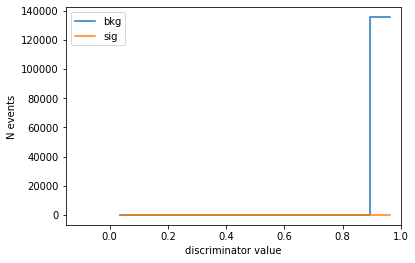

No handles with labels found to put in legend.


[0.87593432]


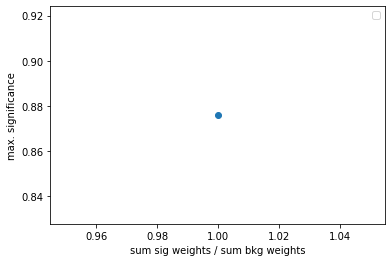

In [216]:
model = buildModel(X_train, y_train, weights_train, 1.0, sigLoss2, 1, 30)

sigHistNN, bkgHistNN, bins = discPlots("BCE", model, X_test, y_test, weights_test)

print("bins = " + str(bins))

binCentres, sigmasNN = getSig(bins, sigHistNN, bkgHistNN) 
    
discBinCentres = (bins[:-1] + bins[1:]) / 2

#scale sig to match bkg normliastion for the sake of illustration
#sigHistNN = ((1.0)/(np.sum(sigHistNN)))*sigHistNN
#bkgHistNN = ((1.0)/(np.sum(bkgHistNN)))*bkgHistNN

print("bins = " + str(discBinCentres))
print("sigHistNN = " + str(sigHistNN))
print("bkgHistNN = " + str(bkgHistNN))

plt.step(discBinCentres, bkgHistNN, label="bkg")
plt.step(discBinCentres, sigHistNN, label="sig")
plt.xlim([-0.15, 1.0])
plt.legend()    
    
maxSig = np.max(sigmasNN)
maxSigs = np.array([])
maxSigs = np.append(maxSigs, maxSig)

plt.xlabel("discriminator value")
plt.ylabel("N events")
plt.legend(loc=2)    
plt.show()

fig, ax2 = plt.subplots()
plt.xlabel("sum sig weights / sum bkg weights")
plt.ylabel("max. significance")

nomScale = np.array([1.0])
print(maxSigs)

fig = plt.errorbar(nomScale, maxSigs, fmt='o', label='')

#ax2.plot(nomScale,maxSigs, label="BCE", lw=5, alpha=0.6)
plt.legend()    
plt.show()